In [1]:
#!/usr/bin/env python
"""
Definition of test problems
--------------------------------------------------------------------------
Created December 10, 2022 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and csanderf@asu.edu; connorsanderford@gmail.com"

In [3]:
import astra
import pylops
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class Tc():
    def __init__(self,**kwargs):
            seed = kwargs.pop('seed',2022)
    def define_proj_id(self, sizex, sizey, views, **kwargs):
            self.dataset = kwargs['dataset'] if ('dataset' in kwargs) else False
            self.nx = sizex
            self.ny = sizey
            self.p = int(np.sqrt(2)*self.nx)    # number of detector pixels
            self.q = views           # number of projection angles
            self.views = views
            self.theta = np.linspace(0, 2*np.pi, self.q, endpoint=False)   # in rad
            self.source_origin = 3*self.nx                     # source origin distance [cm]
            self.detector_origin = self.nx                      # origin detector distance [cm]
            self.detector_pixel_size = (self.source_origin + self.detector_origin)/self.source_origin
            self.detector_length = self.detector_pixel_size*self.p   # detector length
            self.vol_geom = astra.create_vol_geom(self.nx,self.nx)
            self.proj_geom = astra.create_proj_geom('fanflat', self.detector_pixel_size, self.p, self.theta, self.source_origin, self.detector_origin)
            self.proj_id = astra.create_projector('line_fanflat', self.proj_geom, self.vol_geom)
            return self.proj_id

    def define_A(self, sizex, sizey, views): 
            proj_id = self.define_proj_id(sizex, sizey, views)  
            self.A = astra.OpTomo(self.proj_id)     
            return self.A

    def forward_Op(self, x, sizex, sizey, views):
        A = self.define_A(sizex, sizey, views)
        operatorf = lambda X: (A*X.reshape((sizex, sizey))).reshape(-1,1)
        operatorb = lambda B: A.T*B.reshape((self.p, self.q))
        OP = pylops.FunctionOperator(operatorf, operatorb, self.p*self.q, sizex*sizey)
        return OP, A

In [5]:
TT = Tc()

In [6]:
nx = 64
ny = 64
views = 90
x = np.ones((nx*ny,1)) ## assume this is the true phantom
(A, Aformatrix) = TT.forward_Op(x, nx, ny, views)

In [7]:
b = A@x

In [8]:
p = views
q = int(b.shape[0]/p)

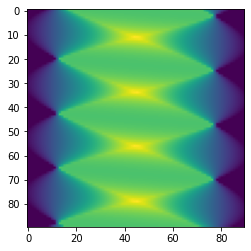

In [9]:
plt.imshow(b.reshape((p,q)))

In [11]:
A.shape
b_vec = b.reshape((-1,1))
b_vec.shape

(8100, 1)

In [15]:
from trips.decompositions import *
b_vec = b.reshape((-1,1))
# Compute a solution Golub-Kahan
projection_dim = 10
(U, B, V) = golub_kahan(A, b_vec, projection_dim)
UU = U[:, 0:-1]
UU.shape


generating basis...: 100%|██████████| 10/10 [00:00<00:00, 81.88it/s]


(8100, 10)

In [17]:
bhat = UU.T@b_vec
bhat.shape

(10, 1)

In [22]:
bhat = U.T@b_vec
y = np.linalg.solve(B.T@B, B.T@bhat)

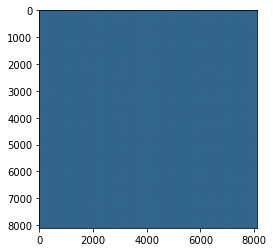

In [47]:
plt.imshow(U@U.T)

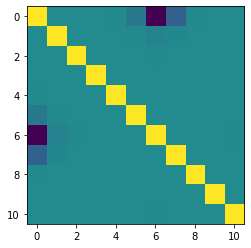

In [48]:
plt.imshow((U.T@U))

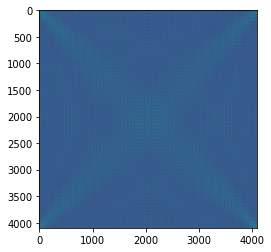

In [49]:
plt.imshow(V@V.T)

In [32]:
V.T@V

array([[ 1.00000000e+00, -3.68645293e-06, -6.84932543e-05,
        -1.53722722e-03, -3.15638686e-02, -4.87388520e-01,
        -8.68066397e-01, -7.99424439e-02, -2.80946591e-03,
         7.84251960e-04],
       [-3.68645293e-06,  1.00000000e+00, -2.69940055e-06,
        -5.99257854e-05, -1.22830619e-03, -1.89604803e-02,
        -3.37670669e-02, -3.10478916e-03, -8.04709805e-05,
         1.71244624e-04],
       [-6.84932543e-05, -2.69940055e-06,  1.00000000e+00,
        -2.80200582e-06, -5.69206749e-05, -8.76857454e-04,
        -1.56087004e-03, -1.42139318e-04,  4.36166121e-06,
         4.72052008e-05],
       [-1.53722722e-03, -5.99257854e-05, -2.80200582e-06,
         1.00000000e+00, -2.43124710e-06, -3.74076808e-05,
        -6.64098485e-05, -5.72140652e-06,  1.99830174e-06,
         9.70253479e-06],
       [-3.15638686e-02, -1.22830619e-03, -5.69206749e-05,
        -2.43124710e-06,  1.00000000e+00, -1.81772431e-06,
        -3.25619601e-06, -2.40409923e-07, -6.29821086e-07,
        -2.

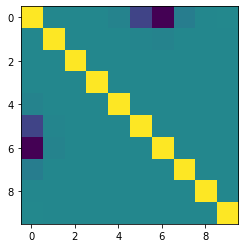

In [33]:
plt.imshow(V.T@V)